# Churn EDA

In [8]:
!pip install shap

## Raw Data

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

df = pd.read_csv('https://github.com/CharlieSergeant/goto-project/raw/main/data/raw/Sample%20Data%20for%20Interview%20Project.csv')


### Select Data

Select and split the attributes into groups or components

In [10]:
## From 1.Data Understanding

target = ['churn']

metadata = ['Account_id', 'contract_start_date', 'contract_end_date']

attributes = ['number_of_employees', 'amount_due_usd', 'quantity_due',
       'monthly_amount_due_usd', 'monthly_price_per_seat_due_usd',
       'total_product_owned', 'dids', 'total_calls', 'total_internal_calls',
       'total_outgoing_calls', 'total_incoming_calls', 'total_forwarded_calls',
       'total_call_duration', 'total_call_jointime',
       'total_call_outbound_duration', 'total_call_inbound_duration',
       'total_incoming_calls_answered', 'total_incoming_calls_notanswered',
       'total_incoming_calls_failed', 'total_incoming_calls_busy',
       'total_outgoing_calls_answered', 'total_outgoing_calls_notanswered',
       'total_outgoing_calls_failed', 'total_outgoing_calls_busy',
       'total_calls_recorded', 'total_calls_not_recorded', 'sum_all_cases',
       'inbound_calls_by_dids', 'outbound_calls_by_dids',
       'inbound_mins_by_dids', 'outbound_mins_by_dids', 'gtm_assigned_seats',
       'total_gtm_sessions_fin', 'total_gtm_session_duration_fin',
       'avg_gtm_session_duration_fin', 'total_gtm_organizers_fin',
       'total_gtm_attendees_fin', 'total_gtm_organizer_duration_fin',
       'total_gtm_attendee_duration_fin', 'total_gtm_pstn_duration_fin',
       'total_gtm_voip_duration_fin', 'total_gtm_webcam_duration_fin',
       'company_size_small_business', 'company_size_large_size_business',
       'company_size_not_available', 'company_size_mid_size_business',
       'market_aus_row', 'market_emea', 'market_latam', 'market_na',
       'support_cases', 'avg_call_quality_score', 'total_ring_group',
       'total_call_queue', 'total_dial_plan', 'virtual_fax_machine']

### Clean Data

As learned from 1.DataUnderstanding we know that the data:
- Does not have missing values
- Has outliers
- All attributes are in 'model ready' format except ```start_contract_date``` and ```end_contract_date```
- Has skewed attributes

I plan on completing the cleaning stage of the data AFTER data transformations to see if engineering new features will help with any of our noted issues

### Transform Data

Feature Engineering

(For sake of time I am not defining all of my created features here but these would all be listed out as follows)

- ```contract_start_year```: Year component of ```contract_start_date```

In [24]:
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import xgboost as xgb
import shap
class CompanySize(Enum):
    LARGE = 3
    MID = 2
    SMALL = 1
    NOT_AVAILABLE = 0

class MarketType(Enum):
    NA = 4
    LATAM = 3
    EMEA = 2
    AUS_ROW = 1
    NOT_AVAILABLE = 0

def apply_company_size(row):
    """
    Assign the company size category based on the presence of a specific column.

    Parameters:
        row (pd.Series): A row of the DataFrame.

    Returns:
        int: The numerical value representing the company size category.
    """
    if row['company_size_large_size_business'] == 1:
        return CompanySize.LARGE.value
    elif row['company_size_mid_size_business'] == 1:
        return CompanySize.MID.value
    elif row['company_size_small_business'] == 1:
        return CompanySize.SMALL.value
    elif row['company_size_not_available'] == 1:
        return CompanySize.NOT_AVAILABLE.value
    else:
        return CompanySize.NOT_AVAILABLE.value  # Default to 0 for 'Unknown'

def transform_company_size(df):
    """
    Transform the company size columns into a single 'company_size' column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with the 'company_size' column.
    """
    df['company_size'] = df.apply(apply_company_size, axis=1)
    df = df.drop(columns=['company_size_large_size_business', 'company_size_mid_size_business', 'company_size_small_business', 'company_size_not_available'])
    return df

def apply_market_type(row):
    """
    Assign the market type category based on the presence of a specific column.

    Parameters:
        row (pd.Series): A row of the DataFrame.

    Returns:
        int: The numerical value representing the market type category.
    """
    if row['market_na'] == 1:
        return MarketType.NA.value
    elif row['market_latam'] == 1:
        return MarketType.LATAM.value
    elif row['market_emea'] == 1:
        return MarketType.EMEA.value
    elif row['market_aus_row'] == 1:
        return MarketType.AUS_ROW.value
    else:
        return MarketType.NOT_AVAILABLE.value  # Default to 0 for 'Unknown'

def transform_market_type(df):
    """
    Transform the market type columns into a single 'market_type' column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with the 'market_type' column.
    """
    df['market_type'] = df.apply(apply_market_type, axis=1)
    df = df.drop(columns=['market_na', 'market_latam', 'market_emea', 'market_aus_row'])
    return df

def transform_start_end_datetimes(df):
    """
    Transform the contract start and end date columns into new features.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with new contract date-related features.
    """
    # Convert the 'contract_start_date' and 'contract_end_date' columns to timestamps
    df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
    df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])

    # Extract year, month, day, and dayofyear components for both columns
    df['contract_start_year'] = df['contract_start_date'].dt.year
    df['contract_start_month'] = df['contract_start_date'].dt.month
    df['contract_start_day'] = df['contract_start_date'].dt.day
    df['contract_start_dayofyear'] = df['contract_start_date'].dt.dayofyear

    df['contract_end_year'] = df['contract_end_date'].dt.year
    df['contract_end_month'] = df['contract_end_date'].dt.month
    df['contract_end_day'] = df['contract_end_date'].dt.day
    df['contract_end_dayofyear'] = df['contract_end_date'].dt.dayofyear

    # Calculate the contract length in seconds
    df['contract_length_in_seconds'] = (df['contract_end_date'] - df['contract_start_date']).dt.total_seconds()

    # CLV
    df['customer_lifetime_value'] = df['contract_length_in_seconds'] * df['amount_due_usd'] * df['quantity_due']

    df = df.drop(columns=['contract_end_date','contract_start_date'])
    return df

def transforms(df):
    """
    Perform a series of data transformations on the input DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    df = df.sort_values('contract_start_date')
    df = transform_company_size(df)
    df = transform_market_type(df)
    df = transform_start_end_datetimes(df)
    df = df.drop(columns=['Account_id'])
    return df

def train_test_split_df(df, test_size=0.2, random_state=None, even=False):
    """
    Perform a train-test split on the input DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        test_size (float): The proportion of the data to include in the test split.
        random_state (int, optional): Seed for the random number generator.
        even (bool, optional): If True, perform stratified split for an even distribution of categories in the target variable.

    Returns:
        pd.DataFrame: X_train (features for training).
        pd.DataFrame: X_test (features for testing).
        pd.Series: y_train (target variable for training).
        pd.Series: y_test (target variable for testing).
    """
    X, y = df.drop(columns=['churn']), df['churn']
    stratify = y if even else None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)
    return X_train, X_test, y_train, y_test

def fit_shap(X, y, visualize=True, save_plot=False, save_path=None):
    """
    Train a Machine Learning Model (XGBoost) and compute SHAP values for feature importance.

    Parameters:
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target variable.
        visualize (bool, optional): If True, create a feature importance plot (Summary Plot).
        save_plot (bool, optional): If True, save the plot instead of displaying it.
        save_path (str, optional): The path to save the plot. Required if save_plot is True.

    Returns:
        xgb.XGBClassifier: The trained XGBoost model.
        shap.Explainer: The SHAP explainer object.
    """
    model = xgb.XGBClassifier()
    model.fit(X, y)

    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)

    average_shap_values = pd.DataFrame(shap_values).mean()
    shap.summary_plot(shap_values, X, plot_type="bar", feature_names=X.columns)
    if save_plot and save_path:
        plt.savefig(save_path)  # Save the plot to the specified path
    if visualize:
        plt.show()
    return model, explainer

def run(disallowed_features=None, visualize=True,save_plot=False, save_path=''):
    """
    Load data, transform it, and train models with and without stratified train-test split.

    """
    df = pd.read_csv('https://github.com/CharlieSergeant/goto-project/raw/main/data/raw/Sample%20Data%20for%20Interview%20Project.csv')
    transformed_df = transforms(df)

    if disallowed_features is not None:
        for disallowed_column in disallowed_features:
            if disallowed_column in transformed_df.columns:
                transformed_df = transformed_df.drop(columns=[disallowed_column])


    print('Running Unstratified fit_shap test...')
    unstratified_X_train, unstratified_X_test, unstratified_y_train, unstratified_y_test = train_test_split_df(transformed_df, test_size=0.2, random_state=42, even=False)
    unstratified_train_model, unstratified_shap = fit_shap(unstratified_X_train, unstratified_y_train, visualize=visualize, save_plot=save_plot, save_path=f'{save_path}unstratified_shap_chart.png')
    unstratified_accuracy = unstratified_train_model.score(unstratified_X_test, unstratified_y_test)
    print("Unstratified Model Accuracy:", unstratified_accuracy)

    print('Running Stratified fit_shap test...')
    stratified_X_train, stratified_X_test, stratified_y_train, stratified_y_test = train_test_split_df(transformed_df, test_size=0.2, random_state=42, even=True)
    stratified_train_model, stratified_shap = fit_shap(stratified_X_train, stratified_y_train, visualize=visualize, save_plot=save_plot, save_path=f'{save_path}stratified_shap_chart.png')
    stratified_accuracy = stratified_train_model.score(stratified_X_test, stratified_y_test)
    print("Stratified Model Accuracy:", stratified_accuracy)


## Pipeline

Running Unstratified fit_shap test...


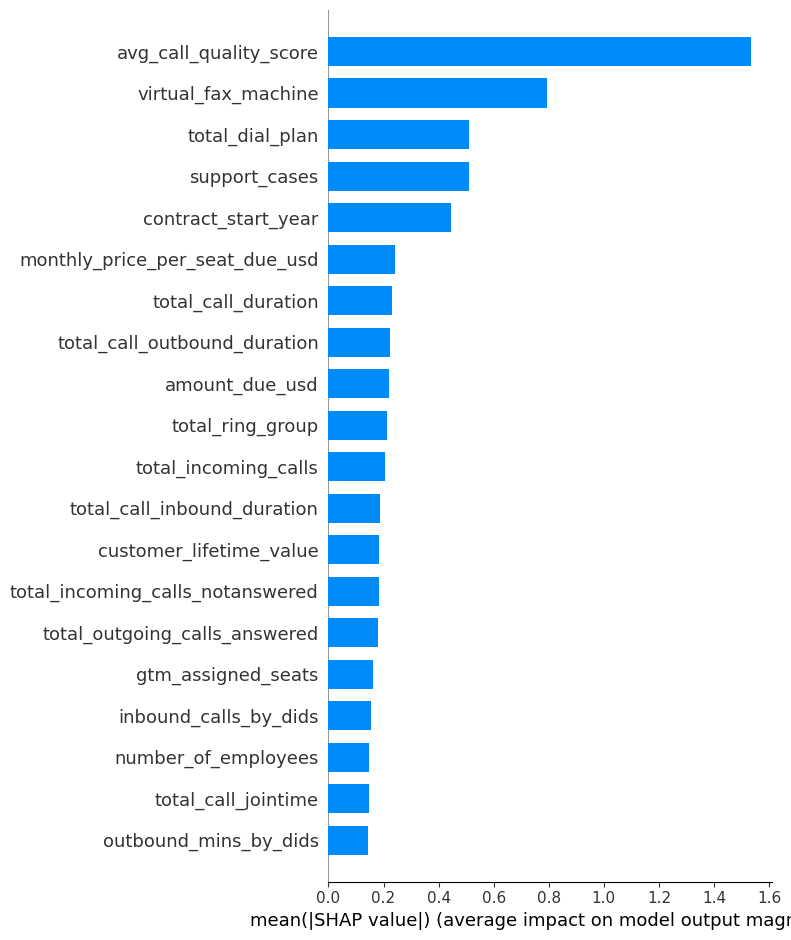

Unstratified Model Accuracy: 0.977
Running Stratified fit_shap test...


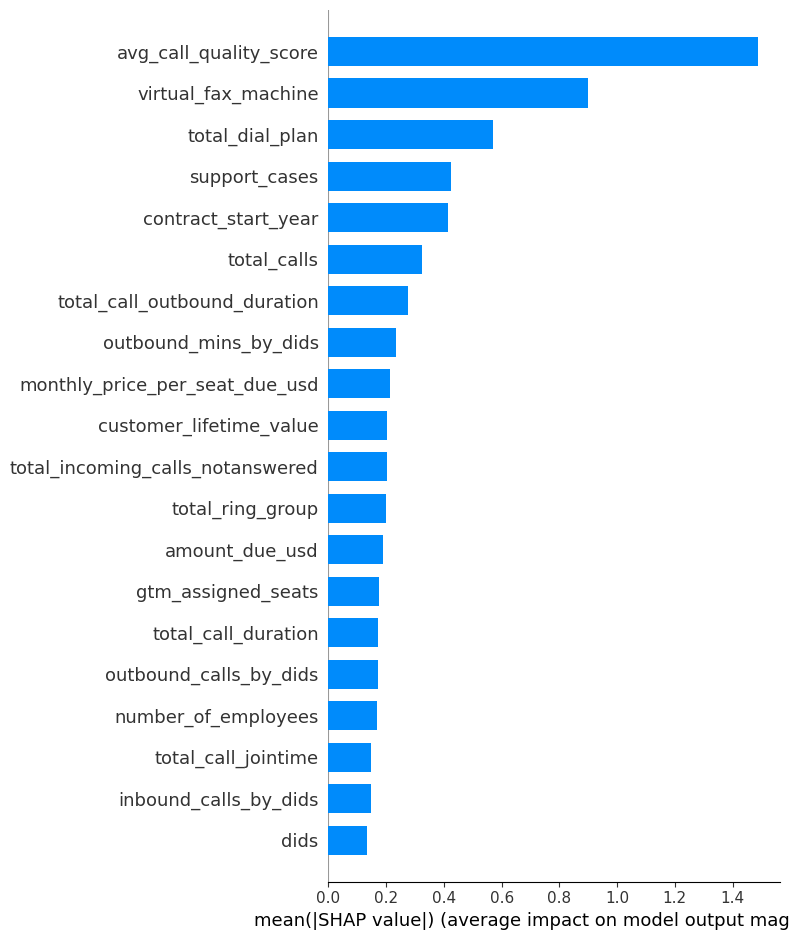

Stratified Model Accuracy: 0.97275


In [22]:
run()

## Additional Analysis

- Visit clustering algorithm on top 10 - 20 features in shap and see if there are some high similarities to churn=1 and churn=0
- Additional data sources
- Additional data cleaning strategies to reduce dimensions
- Additional feature engineering or rules based models to enhance model accuracy
- Such high SHAP score for avg_call_quality_score leads me to believe there is some sort of leakeage there. Below is the same test but with ```avg_call_quality_score``` removed from the attribute list

Running Unstratified fit_shap test...


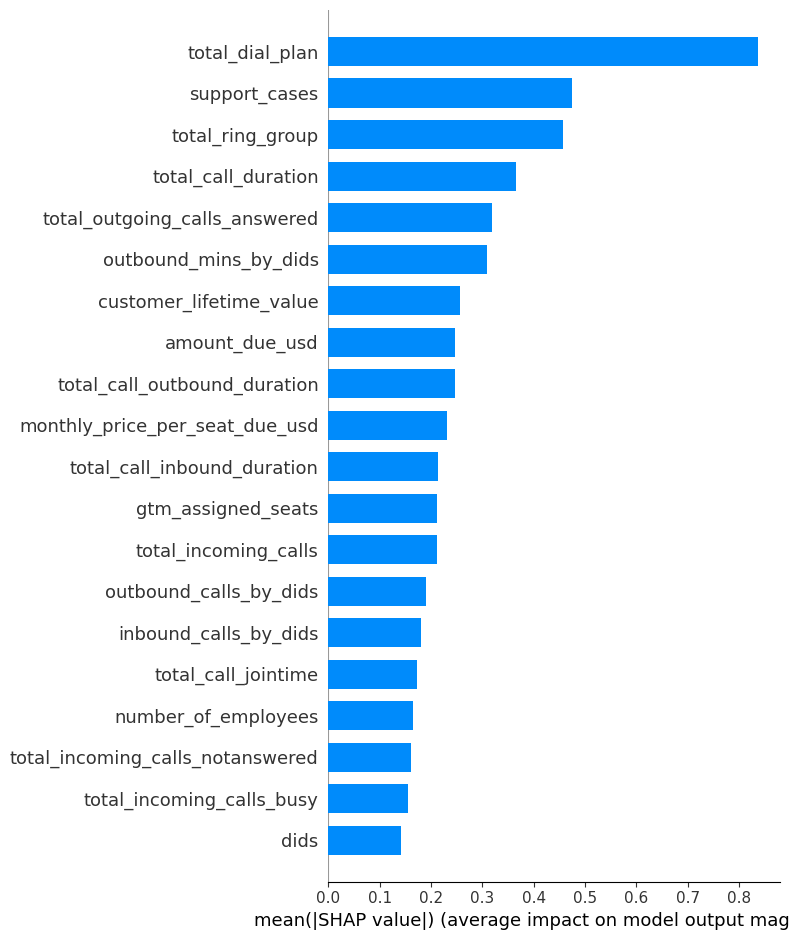

Unstratified Model Accuracy: 0.9765
Running Stratified fit_shap test...


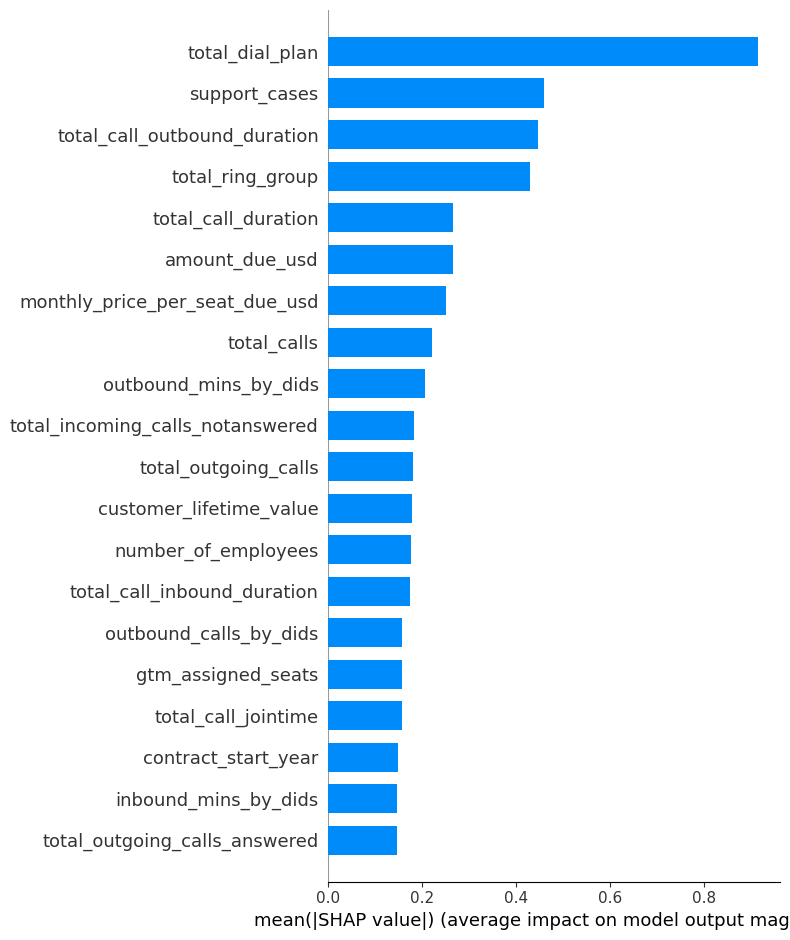

Stratified Model Accuracy: 0.971


In [26]:
run(disallowed_features=['avg_call_quality_score','virtual_fax_machine'])

In [27]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl